In [1]:
from random import seed, uniform

import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
seed(42)
np.random.seed(42)

In [3]:
def create_emoticon(emotion):
    img = np.zeros((64, 64), dtype=np.uint8)

    # Face
    cv2.circle(img, (32, 32), 30, 255, 2)

    # Eyes
    cv2.circle(img, (22, 24), 3, 255, -1)
    cv2.circle(img, (42, 24), 3, 255, -1)

    # Mouth
    if emotion == "smile":
        cv2.ellipse(img, (32, 40), (12, 5), 0, 0, 180, 255, 2)
    elif emotion == "sad":
        cv2.ellipse(img, (32, 40), (12, 5), 0, 180, 360, 255, 2)
    elif emotion == "neutral":
        cv2.line(img, (22, 42), (42, 42), 255, 2)
    elif emotion == "surprise":
        cv2.circle(img, (32, 42), 5, 255, 2)
    else:
        raise ValueError("Unknown emotion: {}".format(emotion))
    return img


def distort_image(img, noise_level=25, deform_shift=8):
    noisy = img.astype(np.float32)
    noisy += np.random.normal(0, noise_level, img.shape)
    noisy = np.clip(noisy, 0, 255)

    rows, cols = img.shape
    pts1 = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    pts2 = np.float32([[0, 0], [cols - 1, 0], [deform_shift, rows - 1]])
    M = cv2.getAffineTransform(pts1, pts2)
    warped = cv2.warpAffine(noisy, M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return warped.astype(np.uint8)


def plot_similar_images(title, query_img, db_images, similarities):
    top_indices = np.argsort(-similarities)[:4]
    top_similarities = similarities[top_indices]
    top_images = [db_images[i] for i in top_indices]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=16, fontweight="bold")

    highest = np.max(top_similarities)

    for i in range(4):
        axes[0, i].axis("off")
    axes[0, 1].imshow(query_img, cmap="gray")
    axes[0, 1].set_title("Query", fontsize=12)

    for i, (img, sim) in enumerate(zip(top_images, top_similarities)):
        axes[1, i].imshow(img, cmap="gray")
        axes[1, i].set_title(f"Similarity: {sim:.4f}", fontsize=10)
        if sim == highest:
            axes[1, i].set_title(
                f"BEST (Similarity: {sim:.4f})", fontsize=10, color="green"
            )
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


def retrieve(db_descriptors, query_descriptor, k=4):
    sims = cosine_similarity([query_descriptor], db_descriptors)[0]
    idx_sorted = np.argsort(-sims)
    top_idx = idx_sorted[:k]
    return top_idx, sims[top_idx], sims


In [4]:
def energy_signature(img_gray, show_kernels=False, show_filtered=False):
    thetas = [np.pi * i / 4 for i in range(4)]
    sigmas = [1.5, 3.0]
    lambdas = [4.0, 8.0]
    descriptors = []

    kernels = []
    filtered_imgs = []

    for sigma in sigmas:
        for theta in thetas:
            for lamb in lambdas:
                kern = cv2.getGaborKernel(
                    (32, 32), sigma, theta, lamb, 0.75, 2, ktype=cv2.CV_32F
                )

                if show_kernels:
                    kernels.append(kern)

                filtered = cv2.filter2D(img_gray, cv2.CV_32F, kern)

                if show_filtered:
                    filtered_imgs.append(filtered)

                energy = np.mean(filtered**2)
                descriptors.append(energy)

    if show_kernels:
        _, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(kernels[i], cmap="gray")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    if show_filtered:
        _, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(filtered_imgs[i], cmap="gray")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    return descriptors / np.linalg.norm(descriptors)

In [5]:
db_labels = ["smile", "sad", "neutral", "surprise"] * 50
db_imgs = [
    distort_image(create_emoticon(emotion), uniform(10, 40), uniform(3, 12))
    for emotion in db_labels
]

db_descriptors = np.array(
    [energy_signature(img.astype(np.float32)) for img in db_imgs]
)
print(f"Descriptors shape: {db_descriptors.shape}")


Descriptors shape: (200, 16)


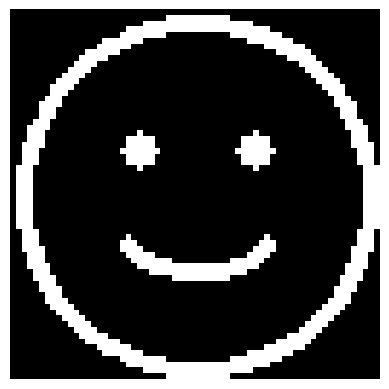

In [6]:
query_img = create_emoticon("smile")

plt.imshow(query_img, cmap="gray")
plt.axis("off")

plt.show()

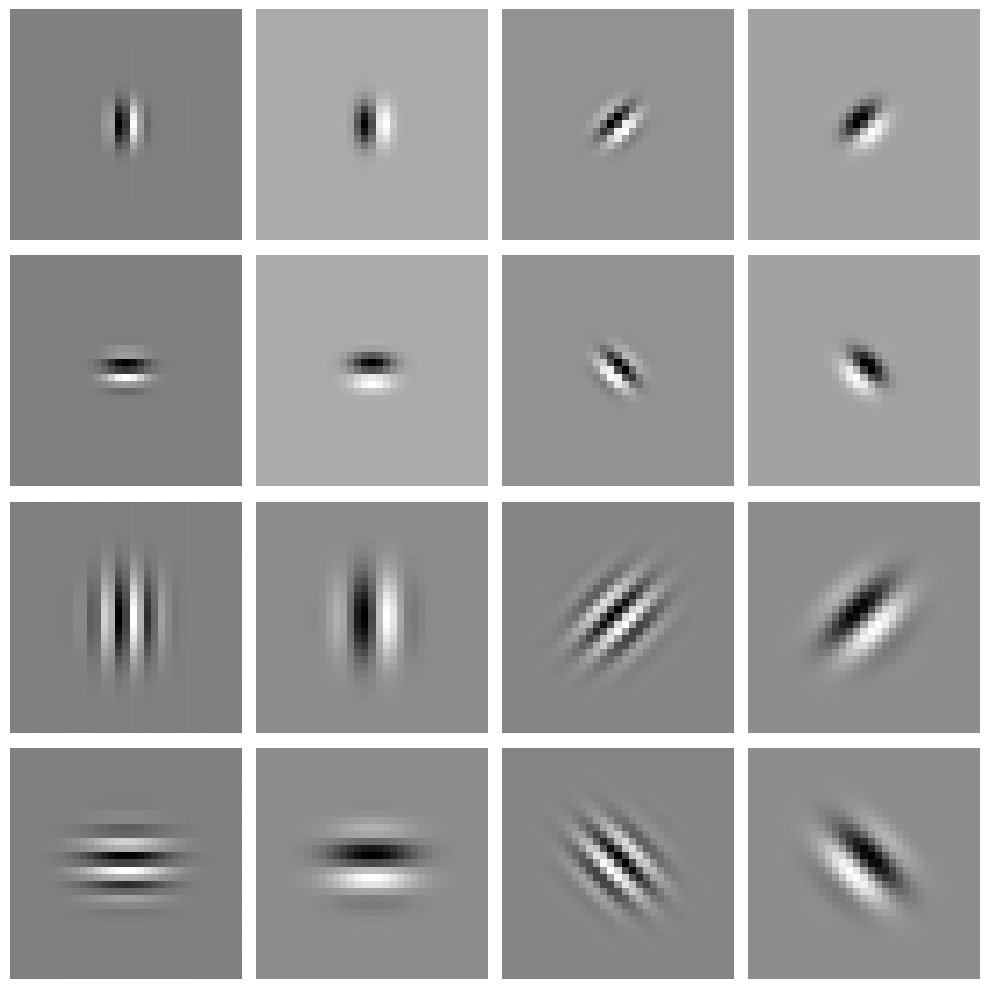

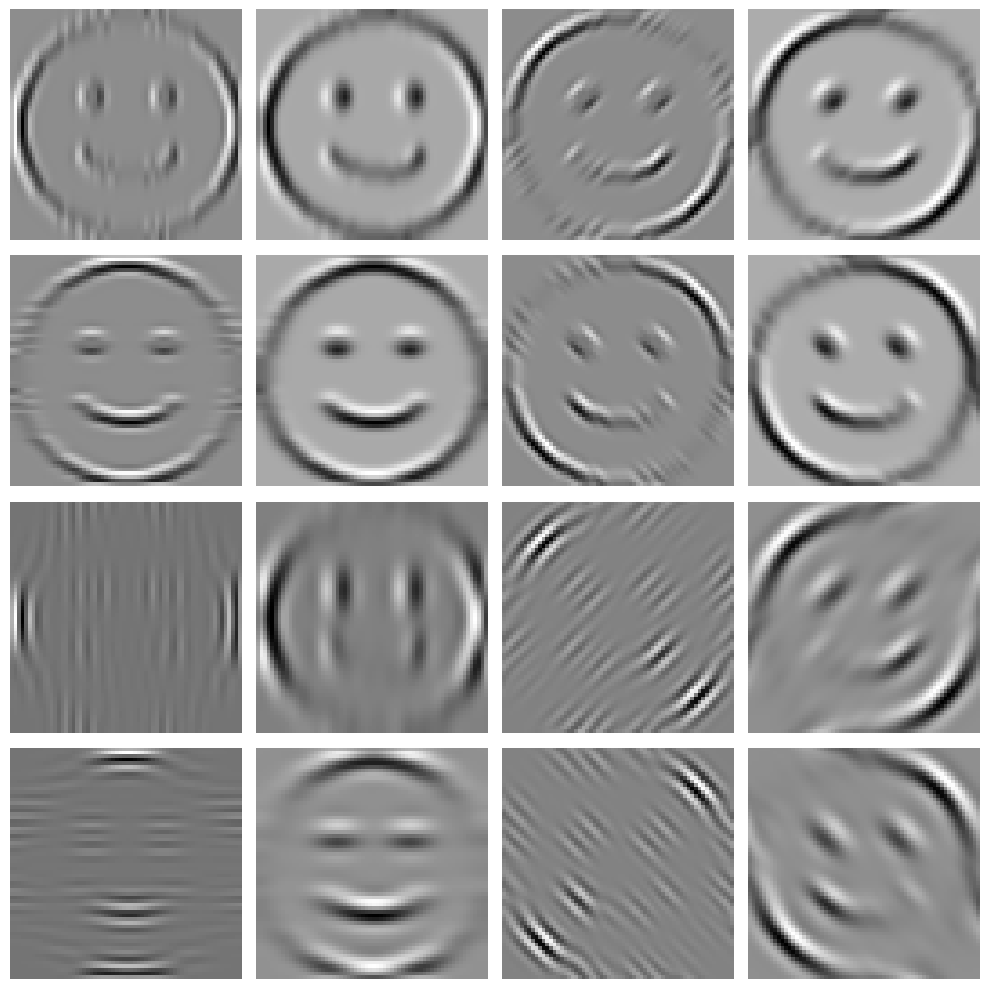

16

In [7]:

query_descriptor = energy_signature(query_img.astype(np.float32), show_kernels=True, show_filtered=True)
query_descriptor.size

Top similarities: [0.9982158 0.9981246 0.9979823 0.9977535]


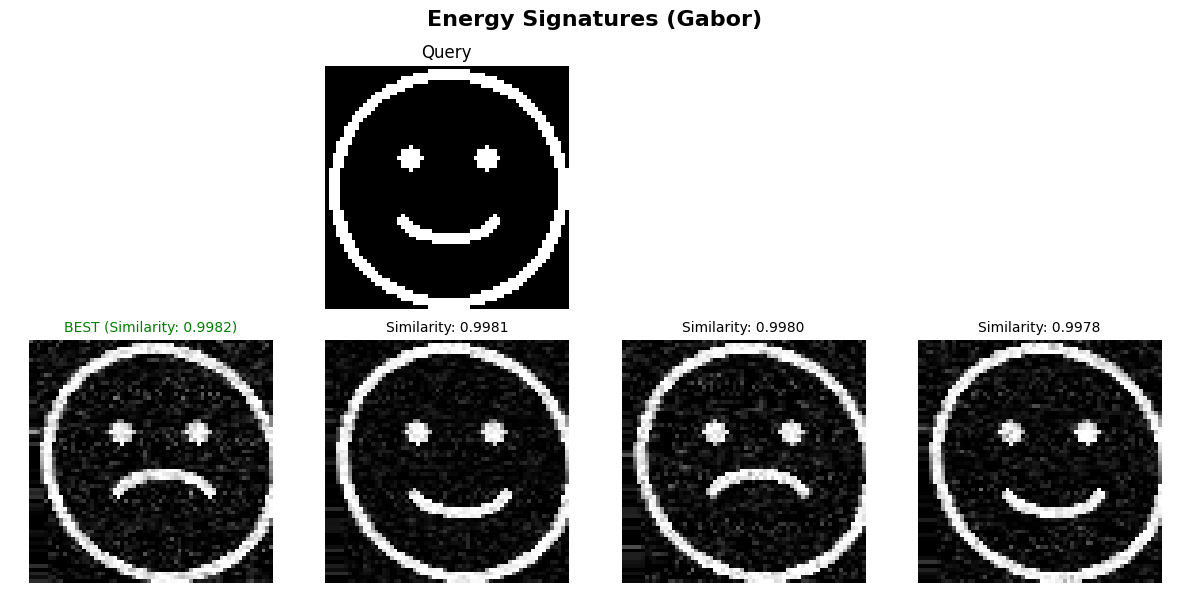

In [8]:
k = 4
top_idx, top_sims, all_sims = retrieve(db_descriptors, query_descriptor, k=k)
print("Top similarities:", top_sims)
plot_similar_images("Energy Signatures (Gabor)", query_img, db_imgs, all_sims)

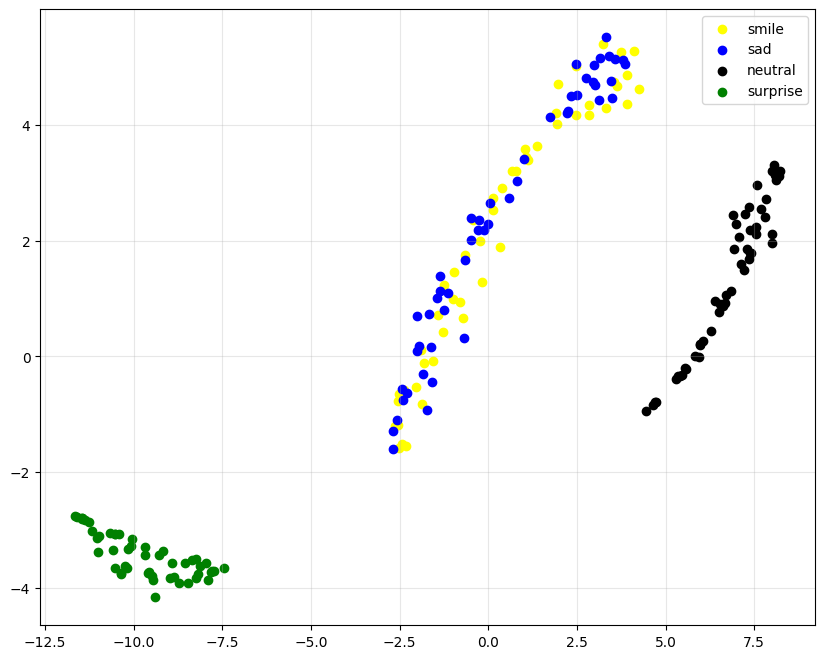

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
encoded_2d = tsne.fit_transform(db_descriptors)
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'smile': 'yellow', 'sad': 'blue', 'neutral': 'black', 'surprise': 'green'}
for emotion in colors:
    idxs = [i for i, label in enumerate(db_labels) if label == emotion]
    ax.scatter(
        encoded_2d[idxs, 0], 
        encoded_2d[idxs, 1], 
        c=colors[emotion], 
        label=emotion, 
    )

ax.legend()
ax.grid(True, alpha=0.3)
plt.show()